# Proposed Model Structured Neural network for the Lateral Dynamics



## Initialization

In [1]:
import os

print('Current working directory: ',os.getcwd())

Current working directory:  c:\Users\mungi\OneDrive\Desktop\Nello\VSD


In [2]:
import sys
import os
import torch
import pandas as pd
import scipy as sp
import numpy as np
from nnodely.support.initializer import *
from nnodely.support.utils import *

print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))
from nnodely import *
from nnodely.support import earlystopping

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-- nnodely_v1.5.1 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Current working directory:  c:\Users\mungi\OneDrive\Desktop\Nello\VSD


## Datasets

In [3]:
from scipy.interpolate import interp1d

data_folder = os.path.join(os.getcwd(),'Dataset')

####### TRAINING DATA ########
data_folder_train = os.path.join(data_folder,'Complete Dynamics/training')
training_data=pd.read_csv(os.path.join(data_folder_train,'ftg_stanley_total_training.csv'))

####### VALIDATION DATA ########
data_folder_Validation = os.path.join(data_folder,'Complete Dynamics/validation')
Validation_data=pd.read_csv(os.path.join(data_folder_Validation,'ftg_stanley_total_validation.csv'))

####### TEST DATA ########

flag=0 # flag to chosse the test dataset
# flag=0 -> fg_single_mass_processed.csv
# flag=1 -> fg_double_mass_processed.csv
# flag=2 -> Frastagliate_tot.csv
# flag=3 -> Intermedie_tot.csv
# flag=4 -> Normal_1weight_v03.csv
# flag=5 -> Normal_2weights_v025.csv

data_folder_Test= os.path.join(data_folder,'Robusteness')

if flag==0:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'single_mass.csv'))
elif flag==1:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'double_mass.csv'))
elif flag==2:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'tire_set_1.csv'))
elif flag==3:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'tire_set_2.csv'))
elif flag==4:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'Normal_1weight.csv'))
elif flag==5:
    Test_data=pd.read_csv(os.path.join(data_folder_Test,'Normal_2weights.csv'))


In [4]:

# -----------------------------------------------
# Neural model inputs and outputs
# -----------------------------------------------
yaw_rate         = Input('yaw_rate')      # [rad/s] yaw rate
vx               = Input('vx')            # [m/s] longitudinal velocity  
steer            = Input('steer')         # [rad] steering wheel angle 
ax               = Input('ax')            # [m/s^2] longitudinal acceleration

ratio_rpm_v=4244.0 # ration between erpm and vehicle speed

# -----------------------------------------------
min_vx_train = min(training_data["Speed"].values/ratio_rpm_v)
max_vx_train = max(training_data["Speed"].values/ratio_rpm_v)

min_delta_train = min(training_data["steering_angle"].values)
max_delta_train = max(training_data["steering_angle"].values)

min_ax_train = min(training_data["accx"].values*9.81)
max_ax_train = max(training_data["accx"].values*9.81)
# -----------------------------------------------
# Hyperparameters
# -----------------------------------------------
# Window size for the inputs
num_samples_past    = 20 # number of samples in the past 

# Number of channels for forward speed
num_channels_vx = 2
num_channels_delta = 5
num_channels_ax = 2

chan_centers_vx = list(np.linspace(min_vx_train-0.3, max_vx_train+0.3, num=num_channels_vx))  # centers of the channels
chan_centers_delta = list(np.linspace(min_delta_train-0.1, max_delta_train+0.1, num=num_channels_delta))  # centers of the channels
chan_centers_ax = list(np.linspace(min_ax_train-0.3, max_ax_train+0.3, num=num_channels_ax))  # centers of the channels

# Define the centers of the channels for ay, ax, and vx:
chan_centers_steer_list, chan_centers_speed_list,chan_centers_ax_list = [], [], []
for idx_steer in range(num_channels_delta):
  chan_centers_steer_list.append(Constant('steer_center_' + str(idx_steer), values=chan_centers_delta[idx_steer]))
for idx_vx in range(num_channels_vx):
  chan_centers_speed_list.append(Constant('vx_center_' + str(idx_vx), values=chan_centers_vx[idx_vx]))
for idx_ax in range(num_channels_ax):
  chan_centers_ax_list.append(Constant('ax_center_' + str(idx_ax), values=chan_centers_ax[idx_ax]))

# -----------------------------------------------
# Understeering gradient correction
# -----------------------------------------------
# Custom function to model the understeering gradient correction
def understeer_corr_local(input,vx,input_0, vx_0,ax,ax_0,  # inputs
                    k1,k2,k3,k4          # learnable parameter 
                  ):
  return vx*(k1+ k2*(input - input_0) + k3* (vx-vx_0) + k4*(ax-ax_0)) 

understeer_corr = ParamFun(understeer_corr_local)

def understeer_corr_gen(idx_list):
  def understeer_corr_map(input,vx,ax):
    idx_ax=idx_list[2]
    idx_steer=idx_list[1]
    idx_speed=idx_list[0]
    k1 = Parameter('k1_'+ str(idx_speed)+ '_' + str(idx_steer)+ '_' + str(idx_ax),values=[[1e-5]])  # initial guess for the understeering gradient learnable parameter
    k2 = Parameter('k2_'+ str(idx_speed)+ '_' + str(idx_steer)+ '_' + str(idx_ax),values=[[1e-5]])  # initial guess for the understeering gradient learnable parameter
    k3 = Parameter('k3_'+ str(idx_speed)+ '_' + str(idx_steer)+ '_' + str(idx_ax),values=[[1e-5]])  # initial guess for the understeering gradient learnable parameter
    k4 = Parameter('k4_'+ str(idx_speed)+ '_' + str(idx_steer)+ '_' + str(idx_ax),values=[[1e-5]])  # initial guess for the understeering gradient learnable parameter

    input_0 = chan_centers_steer_list[idx_steer]
    vx_0 = chan_centers_speed_list[idx_speed]
    ax_0 = chan_centers_ax_list[idx_ax]
    return understeer_corr(input,vx,input_0,vx_0,ax,ax_0,
                           k1,k2,k3,k4)
  return understeer_corr_map

fuzz_lateral_transient = Fuzzify(centers=chan_centers_vx, functions='Triangular')(vx.sw(num_samples_past))
fuzz_ax_transient = Fuzzify(centers=chan_centers_ax, functions='Triangular')(ax.sw(num_samples_past))

fuzz_lateral_ss_2 = Fuzzify(centers=chan_centers_delta, functions='Triangular')(steer.sw(num_samples_past))
fuzz_lateral_ss_1 = Fuzzify(centers=chan_centers_vx, functions='Triangular')(vx.sw(num_samples_past))
fuzz_lateral_ss_3 = Fuzzify(centers=chan_centers_ax, functions='Triangular')(ax.sw(num_samples_past))

# Parametric function to model the understeering gradient correction
local_model_ss = LocalModel(input_function=understeer_corr_gen,pass_indexes=True)((steer.sw(num_samples_past), vx.sw(num_samples_past),ax.sw(num_samples_past))
                                                                                  , (fuzz_lateral_ss_1, fuzz_lateral_ss_2,fuzz_lateral_ss_3))

local_model_transient = LocalModel(output_function=lambda: Fir(W_init = init_exp, W_init_params={'size_index':0, 'max_value':1, 'lambda':5, 'monotonicity':'increasing'}))(local_model_ss, (fuzz_lateral_transient,fuzz_ax_transient))

# Model output: trajectory curvature at the current time step
yaw_rate_out = Output('yaw_rate_', local_model_transient)  # output of the model 

### nnodely definitions

In [5]:
# Create a nnodely model
path_folder   = os.path.join(os.getcwd(),'trained_models','Lateral_Dynamics_Ablation_1')    # folder to save the model without auto-regression
lateral_dynamics   = nnodely(visualizer='Standard',seed=12,workspace=path_folder,save_history=False)  #visualizer=MPLVisulizer()

# Add the neural model to the nnodely structure and neuralization of the model
lateral_dynamics.addModel('yaw_rate',[yaw_rate_out])
lateral_dynamics.addMinimize('yaw_rate_error', 
                                    yaw_rate.next(),  # next means the first value in the "future"
                                    yaw_rate_out, 
                                    loss_function='rmse')


In [6]:
lateral_dynamics.neuralizeModel()

================================ nnodely Model =================================
{'Constants': {'ax_center_0': {'dim': 1, 'values': [-5.072999000549316]},
               'ax_center_1': {'dim': 1, 'values': [6.059031963348389]},
               'steer_center_0': {'dim': 1, 'values': [-0.3695776164531708]},
               'steer_center_1': {'dim': 1, 'values': [-0.14745821058750153]},
               'steer_center_2': {'dim': 1, 'values': [0.07466120272874832]},
               'steer_center_3': {'dim': 1, 'values': [0.29678061604499817]},
               'steer_center_4': {'dim': 1, 'values': [0.5189000368118286]},
               'vx_center_0': {'dim': 1, 'values': [-0.624546229839325]},
               'vx_center_1': {'dim': 1, 'values': [3.9042770862579346]}},
 'Functions': {'FFuzzify15': {'centers': [-0.6245462443934415,
                                          3.9042770373580393],
                              'dim_out': {'dim': 2},
                              'functions': 'Triangular

## Training and validation datasets

In [7]:
perc=1.0 # percentage of data used for training 

speed_ms_train=(training_data["Speed"].values)/ratio_rpm_v
steer_rads_train=training_data["steering_angle"].values
yaw_rate_train=np.deg2rad(training_data["yaw_rate"].values)
ax_train=-training_data["accx"].values*9.81
size_train= round(len(steer_rads_train)*perc)
dataset_training = {'steer': steer_rads_train[:size_train], 'vx': speed_ms_train[:size_train], 'yaw_rate' : yaw_rate_train[:size_train],'ax':ax_train[:size_train]}

speed_ms_validation=(Validation_data["Speed"].values)/ratio_rpm_v
steer_rads_validation=Validation_data["steering_angle"].values
yaw_rate_validation=np.deg2rad(Validation_data["yaw_rate"].values)
ax_validation=-Validation_data["accx"].values*9.81

dataset_validation = {'steer': steer_rads_validation[:], 'vx': speed_ms_validation[:], 'yaw_rate' : yaw_rate_validation[:],'ax':ax_validation[:]}

speed_ms_test=(Test_data["Speed"].values)/ratio_rpm_v
steer_rads_test=Test_data["steering_angle"].values
yaw_rate_test=np.deg2rad(Test_data["yaw_rate"].values)
ax_test=-Test_data["accx"].values*9.81

dataset_test = {'steer': steer_rads_test[:], 'vx': speed_ms_test[:], 'yaw_rate' : yaw_rate_test[:],'ax':ax_test[:]}

# Pass the training and the validation datasets to the nnodely structure

lateral_dynamics.loadData(name='training_set', source=dataset_training)
lateral_dynamics.loadData(name='validation_set', source=dataset_validation)
lateral_dynamics.loadData(name='Test_set', source=dataset_test)

============================ nnodely Model Dataset =============================
Dataset Name:                 training_set
Number of files:              1
Total number of samples:      2511
Shape of ax:                  (2511, 20, 1)
Shape of vx:                  (2511, 20, 1)
Shape of steer:               (2511, 20, 1)
Shape of yaw_rate:            (2511, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 validation_set
Number of files:              1
Total number of samples:      1177
Shape of ax:                  (1177, 20, 1)
Shape of vx:                  (1177, 20, 1)
Shape of steer:               (1177, 20, 1)
Shape of yaw_rate:            (1177, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 Test_set
Number of files:              1
Total number of samples:      499
Shape of ax:                  (499, 20, 1)
Shape of vx:                  (499, 2

## Training

In [ ]:
num_epochs = 1500
batch_size = 100
learn_rate = 1e-3
early_stop_patience = 300 
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate}

flag_train_now = 1
if flag_train_now:
  train_result_open_loop = lateral_dynamics.trainAndAnalyze(train_dataset='training_set',  validation_dataset= 'validation_set', test_dataset= 'Test_set',
                                                              training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                              early_stopping=earlystopping.early_stop_patience,  
                                                              early_stopping_params={'patience':early_stop_patience,
                                                                                    'error':'yaw_rate_error'})
  lateral_dynamics.saveModel()  
else:
  # Load the trained model
  lateral_dynamics.loadModel() 
  lateral_dynamics.neuralizeModel()

======================== nnodely Model Train Parameters ========================
models:                       ['yaw_rate']
num of epochs:                7000
update per epochs:            25
└>(n_samples-batch_size)/batch_size+1
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'yaw_rate_error', 'patience': 300}
train dataset:                training_set
	- batch size:                100
	- num of samples:            2511
validation dataset:           validation_set
	- batch size:                100
	- num of samples:            1177
minimizers:                   {'yaw_rate_error': {'A': 'SamplePart484',
                                                  'B': 'Add482',
                                                  'loss': 'rmse'}}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.001}
optimizer params:             [{'params': 'PFir102W'},
                               {'params': 'PFi

## Fine Tuning

In [9]:
#########################################
# Fine-tuning of the model
#########################################
num_epochs = 60
batch_size = 100
learn_rate = 1e-3
early_stop_patience = 30 
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate}
'''
                #'lr_param':{'PFir101W':0,'PFir103W':0,'PFir105W':0,'PFir107W':0}}
                
                 'lr_param':{'k1_0_0_0':0,'k1_0_0_1':0,'k1_0_1_0':0,'k1_0_1_1':0,
                             'k1_0_2_0':0,'k1_0_2_1':0,'k1_0_3_0':0,'k1_0_3_1':0,
                             'k1_0_4_0':0,'k1_0_4_1':0,'k1_1_0_0':0,'k1_1_0_1':0,
                             'k1_1_1_0':0,'k1_1_1_1':0,'k1_1_2_0':0,'k1_1_2_1':0,
                             'k1_1_3_0':0,'k1_1_3_1':0,'k1_1_4_0':0,'k1_1_4_1':0,
                             'k2_0_0_0':0,'k2_0_0_1':0,'k2_0_1_0':0,'k2_0_1_1':0,
                             'k2_0_2_0':0,'k2_0_2_1':0,'k2_0_3_0':0,'k2_0_3_1':0,
                             'k2_0_4_0':0,'k2_0_4_1':0,'k2_1_0_0':0,'k2_1_0_1':0,
                             'k2_1_1_0':0,'k2_1_1_1':0,'k2_1_2_0':0,'k2_1_2_1':0,
                             'k2_1_3_0':0,'k2_1_3_1':0,'k2_1_4_0':0,'k2_1_4_1':0,
                             'k3_0_0_0':0,'k3_0_0_1':0,'k3_0_1_0':0,'k3_0_1_1':0,
                             'k3_0_2_0':0,'k3_0_2_1':0,'k3_0_3_0':0,'k3_0_3_1':0,
                             'k3_0_4_0':0,'k3_0_4_1':0,'k3_1_0_0':0,'k3_1_0_1':0,
                             'k3_1_1_0':0,'k3_1_1_1':0,'k3_1_2_0':0,'k3_1_2_1':0,
                             'k3_1_3_0':0,'k3_1_3_1':0,'k3_1_4_0':0,'k3_1_4_1':0,
                             'k4_0_0_0':0,'k4_0_0_1':0,'k4_0_1_0':0,'k4_0_1_1':0,
                             'k4_0_2_0':0,'k4_0_2_1':0,'k4_0_3_0':0,'k4_0_3_1':0,
                             'k4_0_4_0':0,'k4_0_4_1':0,'k4_1_0_0':0,'k4_1_0_1':0,
                             'k4_1_1_0':0,'k4_1_1_1':0,'k4_1_2_0':0,'k4_1_2_1':0,
                             'k4_1_3_0':0,'k4_1_3_1':0,'k4_1_4_0':0,'k4_1_4_1':0
                             }}
                             '''

flag_train_now_fine_tuning = 0
if flag_train_now_fine_tuning:
  train_result_open_loop = lateral_dynamics.trainModel(train_dataset='Test_set', validation_dataset= 'training_set', # test_dataset= 'Test_set',
                                                              training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                              early_stopping=earlystopping.early_stop_patience,  
                                                              early_stopping_params={'patience':early_stop_patience,
                                                                                    'error':'yaw_rate_error'})  
else:
  # Load the trained model
  lateral_dynamics.loadModel() 

=============================== Load JSON Model ================================
Model loaded from:            c:\Users\mungi\OneDrive\Desktop\Nello\VSD\trained_models\Lateral_Dynamics_Ablation_1\net.json


In [10]:
# Print the trained NN parameters
lateral_dynamics.neuralizeModel()

================================ nnodely Model =================================
{'Constants': {'ax_center_0': {'dim': 1, 'values': [-5.072999000549316]},
               'ax_center_1': {'dim': 1, 'values': [6.059031963348389]},
               'steer_center_0': {'dim': 1, 'values': [-0.3695776164531708]},
               'steer_center_1': {'dim': 1, 'values': [-0.14745821058750153]},
               'steer_center_2': {'dim': 1, 'values': [0.07466120272874832]},
               'steer_center_3': {'dim': 1, 'values': [0.29678061604499817]},
               'steer_center_4': {'dim': 1, 'values': [0.5189000368118286]},
               'vx_center_0': {'dim': 1, 'values': [-0.624546229839325]},
               'vx_center_1': {'dim': 1, 'values': [3.9042770862579346]}},
 'Functions': {'FFuzzify15': {'centers': [-0.6245462443934415,
                                          3.9042770373580393],
                              'dim_out': {'dim': 2},
                              'functions': 'Triangular

## Results

RMSE on the test set:  [0.11686969]  rad^2


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

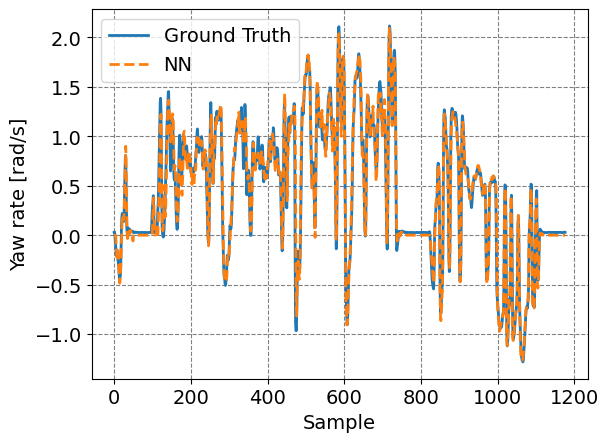

In [11]:
# Test on a new dataset
num_samples_use  = np.size(yaw_rate_validation)-num_samples_past
samples_Validation_set = lateral_dynamics.getSamples('validation_set', index=0, window=num_samples_use) 
out_nn_test_set  = lateral_dynamics(samples_Validation_set, sampled=True)
out_nn_Validation_set_extract = np.asarray(out_nn_test_set['yaw_rate_'])

# Extract the samples
samples_Validation_set_extract = np.zeros((len(samples_Validation_set['yaw_rate']),1))
for i in range(0,len(samples_Validation_set_extract)):
  samples_Validation_set_extract[i] = samples_Validation_set['yaw_rate'][i]

# Compute the RMSE on the test set
mse_calc = 0
for i in range(0,len(samples_Validation_set_extract)):
  mse_calc = mse_calc + (samples_Validation_set_extract[i] - out_nn_Validation_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_Validation_set_extract))
print('RMSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot((samples_Validation_set_extract
            ),label='Ground Truth',linewidth=2)
  plt.plot((out_nn_Validation_set_extract
            ),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()

RMSE on the test set:  [0.07984356]  rad^2


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

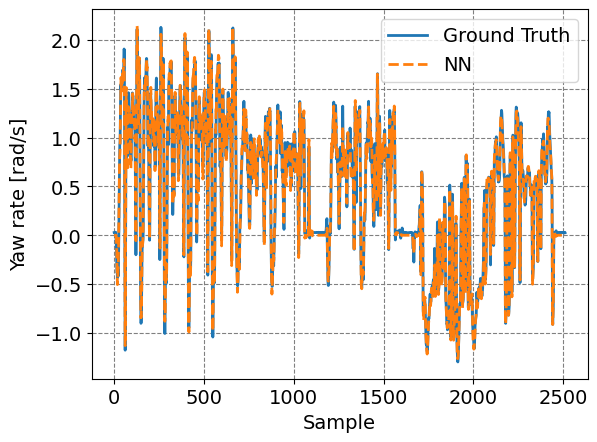

In [12]:
# Test on a new dataset
num_samples_use  = size_train-num_samples_past
samples_training_set = lateral_dynamics.getSamples('training_set', index=0, window=num_samples_use) 
out_nn_trainig_set  = lateral_dynamics(samples_training_set, sampled=True)
out_nn_training_set_extract = np.asarray(out_nn_trainig_set['yaw_rate_'])

# Extract the samples
samples_training_set_extract = np.zeros((len(samples_training_set['yaw_rate']),1))
for i in range(0,len(samples_training_set_extract)):
  samples_training_set_extract[i] = samples_training_set['yaw_rate'][i]

# Compute the RMSE on the test set
mse_calc = 0
for i in range(0,len(samples_training_set_extract)):
  mse_calc = mse_calc + (samples_training_set_extract[i] - out_nn_training_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_training_set_extract))
print('RMSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot((samples_training_set_extract
            ),label='Ground Truth',linewidth=2)
  plt.plot((out_nn_training_set_extract
            ),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()


RMSE on the test set:  [0.19653207]  rad^2


c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\envs\m

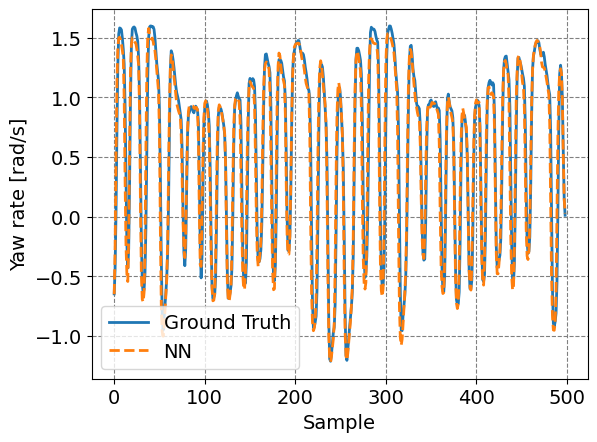

In [13]:
# Test on a new dataset
num_samples_use  = np.size(yaw_rate_test)-num_samples_past
samples_test_set = lateral_dynamics.getSamples('Test_set', index=0, window=num_samples_use) 
out_nn_test_set  = lateral_dynamics(samples_test_set, sampled=True)
out_nn_test_set_extract = np.asarray(out_nn_test_set['yaw_rate_'])

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['yaw_rate']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['yaw_rate'][i]

# Compute the RMSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_test_set_extract))
print('RMSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot((samples_test_set_extract
            ),label='Ground Truth',linewidth=2)
  plt.plot((out_nn_test_set_extract
            ),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Yaw rate [rad/s]')
  plt.legend()
  plt.grid()
  plt.show()
